In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from utils.load_data import load_behavioral_data
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


##### Load the data
Remove RT outliers (defined as any response time less than 0.2 seconds). This also eliminates the trials where the subject did not respond.

In [9]:
data = load_behavioral_data(min_RT = 0.2)
shared_gains = [10, 12, 14, 16, 18, 20]

In [15]:
print("High reward mean acceptance rate:", data.query("condition == 'equalIndifference' & gain in @shared_gains")["accept"].mean())
print("Low reward mean acceptance rate:", data.query("condition == 'equalRange' & gain in @shared_gains")["accept"].mean())

High reward mean acceptance rate: 0.3714785311832135
Low reward mean acceptance rate: 0.5766011290636558


### Analysis of acceptance rate
**Question: How does gain and loss affect acceptance rate? Does it change based on the condition?**

Model 1: Predict acceptance rate as a function of condition, gain and loss

In [59]:
%%R -i data
library(lme4)
library(lmerTest)

In [60]:
%%R
model1 <- glmer(prob_accept ~ condition*gain + condition*loss + (1|sub), data=data, family=binomial)
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: prob_accept ~ condition * gain + condition * loss + (1 | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 16384.9  16442.4  -8185.5  16370.9    27436 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-65.931  -0.240   0.027   0.236  40.372 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 2.471    1.572   
Number of obs: 27443, groups:  sub, 108

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               0.285352   0.238004   1.199   0.2306    
conditionequalRange      -0.787039   0.333688  -2.359   0.0183 *  
gain                      0.273216   0.005310  51.455  < 2e-16 ***
loss                     -0.435093   0.009278 -46.896  < 2e-16 ***
conditionequalRange:gain  0.236106   0.011028  21.409  < 2e-16 ***
conditionequalRange:loss -0.077643   0.013410 

In addition: Warning message:
In eval(family$initialize, rho) : non-integer #successes in a binomial glm!


In [61]:
%%R
# Model comparison 
model2 <- glmer(prob_accept ~ condition + gain + loss + (1|sub), data=data, family=binomial)
anova(model1, model2)

Data: data
Models:
model2: prob_accept ~ condition + gain + loss + (1 | sub)
model1: prob_accept ~ condition * gain + condition * loss + (1 | sub)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model2    5 17045 17086 -8517.6    17035                         
model1    7 16385 16442 -8185.5    16371 664.25  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In addition: Warning message:
In eval(family$initialize, rho) : non-integer #successes in a binomial glm!


**Findings:**
1. No significant effect of condition on acceptance rate
2. For the high reward condition, there is a significant effect of gain on acceptance rate.
    * Log-odds increases by 0.321 (w/ all participants, its 0.293)
3. For the low reward condition, there is a significant effect of gain on acceptance rate.
    * Log-odds increases by 0.707 (w/ all participants, its 0.528)
4. For the high reward condition, there is a significant effect of loss on acceptance rate.
    * Log-odds decreases by 0.476 (w/ all participants, its 0.468)
5. For the low reward condition, there is a significant effect of loss on acceptance rate.
    * Log-odds decreases by 0.683 (w/ all participants, its 0.532)

For high reward, the ratio for loss/gain is 0.476/0.321 = 1.483 (loss averse behavior, w/ all participants its 1.802). For low reward, the ratio for loss/gain is 0.683/0.707 = 0.966 (not loss averse, w/ all participants its 1.151).

After model comparison, we find that gain and loss interact with the condition. 

### Analysis of response time
**Question: What are the differences in response time between conditions? Are acceptances faster than rejections between conditions?**

Model 2: Predict response time as a function of condition, gain, loss, distance from indifference and response.


In [16]:
equalIndiff_rows = data["condition"] == "equalIndifference"
data.loc[equalIndiff_rows, "dist_from_indiff"] = np.abs(data[equalIndiff_rows]["gain"] - 1.5*data[equalIndiff_rows]["loss"]) / np.square(1 + 1.5**2)
equalRange_rows = data["condition"] == "equalRange"
data.loc[equalRange_rows, "dist_from_indiff"] = np.abs(data[equalRange_rows]["gain"] - 1*data[equalRange_rows]["loss"]) / np.square(1 + 1**2)

In [46]:
data["dist_from_indiff_high"] = np.abs(data["gain"] - 1.8*data["loss"]) / np.square(1 + 1.8**2)
data["dist_from_indiff_low"] = np.abs(data["gain"] - 1.2*data["loss"]) / np.square(1 + 1.2**2)

In [47]:
%%R -i data
# Is there an effect of accepting on response time between conditions? And if so, is this due to the gain and loss?
# Model 2: Predict Response Time as a function of condition, gain, loss, distance from indifference and response.
model3 <- lmer(RT ~ gain*condition + loss*condition + dist_from_indiff_low*condition + dist_from_indiff_high*condition+ (1|sub), data=data)
summary(model3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain * condition + loss * condition + dist_from_indiff_low *  
    condition + dist_from_indiff_high * condition + (1 | sub)
   Data: data

REML criterion at convergence: 39730.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7326 -0.6709 -0.1576  0.5088  5.4110 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.1059   0.3253  
 Residual             0.2438   0.4937  
Number of obs: 27443, groups:  sub, 108

Fixed effects:
                                            Estimate Std. Error         df
(Intercept)                                1.763e+00  4.770e-02  1.403e+02
gain                                       5.026e-04  1.240e-03  2.733e+04
conditionequalRange                       -1.449e-01  6.744e-02  1.401e+02
loss                                       1.268e-02  1.450e-03  2.733e+04
dist_from_indiff_low                      -2.832e-0

In [30]:
import scipy.stats as stats
p_values = stats.false_discovery_control([2e-16, 0.6852, 0.0334, 2e-16, 0.009, 2e-16, 0.118, 0.7627, 2e-16, 2.27e-16], method = "by")
p_values

array([1.32975159e-15, 1.00000000e+00, 1.39753628e-01, 1.32975159e-15,
       4.39345238e-02, 1.32975159e-15, 4.32022817e-01, 1.00000000e+00,
       1.32975159e-15, 1.32975159e-15])

In [48]:
%%R
# Post-hoc tests for condition equalRange (low reward)
model4 <- lmer(RT ~ gain + loss + dist_from_indiff_low + dist_from_indiff_high + (1  |sub), data=data[data$condition == 'equalRange', ])
model4b <- lmer(RT ~ gain + loss + dist_from_indiff_low  + (1  |sub), data=data[data$condition == 'equalRange', ])
anova(model4, model4b)

Data: data[data$condition == "equalRange", ]
Models:
model4b: RT ~ gain + loss + dist_from_indiff_low + (1 | sub)
model4: RT ~ gain + loss + dist_from_indiff_low + dist_from_indiff_high + (1 | sub)
        npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
model4b    6 18841 18886 -9414.6    18829                     
model4     7 18842 18894 -9413.8    18828 1.7532  1     0.1855


refitting model(s) with ML (instead of REML)


In [49]:
%%R
# Post-hoc tests for condition equalRange (low reward)
model4 <- lmer(RT ~ gain + loss + dist_from_indiff_low + dist_from_indiff_high + (1  |sub), data=data[data$condition == 'equalIndifference', ])
model4b <- lmer(RT ~ gain + loss + dist_from_indiff_high  + (1  |sub), data=data[data$condition == 'equalIndifference', ])
anova(model4, model4b)

Data: data[data$condition == "equalIndifference", ]
Models:
model4b: RT ~ gain + loss + dist_from_indiff_high + (1 | sub)
model4: RT ~ gain + loss + dist_from_indiff_low + dist_from_indiff_high + (1 | sub)
        npar   AIC   BIC logLik deviance  Chisq Df Pr(>Chisq)  
model4b    6 20769 20814 -10378    20757                       
model4     7 20764 20817 -10375    20750 6.3797  1    0.01154 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


refitting model(s) with ML (instead of REML)


In [63]:
%%R
# Post-hoc tests for condition equalIndifference (high reward)
model5 <- lmer(RT ~ gain + loss + dist_from_indiff + accept + (1 + accept|sub), data=data[data$condition == 'equalIndifference', ])
summary(model5)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + dist_from_indiff + accept + (1 + accept |      sub)
   Data: data[data$condition == "equalIndifference", ]

REML criterion at convergence: 20072.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6410 -0.6666 -0.1530  0.4902  5.3207 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 sub      (Intercept) 0.11486  0.3389        
          accept      0.09832  0.3136   -0.36
 Residual             0.24453  0.4945        
Number of obs: 13727, groups:  sub, 54

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       1.885e+00  5.035e-02  7.058e+01  37.439   <2e-16 ***
gain              6.103e-04  6.087e-04  1.367e+04   1.003   0.3160    
loss              1.215e-02  1.101e-03  1.366e+04  11.030   <2e-16 ***
dist_from_indiff -4.454e-01  1.165e-02  1.366e+04 -38.246   <2e-16 ***
accept           -1.006e-0

**Findings:**
1. Condition has no significant effect on response time.
2. In high reward condition, there is a significant effect of gain on response time.
    * Beta of 0.021 (0.023 w/ all participants)
3. In low reward condition, there is a significant effect of gain on response time.
    * Beta of 0.001 (0.003 w/ all participants)
    * This is slightly significant after post-hoc analysis. 
4. In high reward condition, there is not a significant effect of loss on response time.
5. In low reward condition, there is a significant effect of loss on response time.
    * Beta of 0.009
6. In high reward condition, there is a significant effect of distance from indifference on response time.
    * Beta of -0.05
7. In low reward condition, there is not a significant effect of distance from indifference on response time.
    * Beta of -0.03
8. In high reward condition, there is a significant effect of accepting on response time.
    * Beta of 0.098
9. In low reward condition, there is a significant effect of accepting on response time.
    * Beta of -0.01
    * This is not significant after post-hoc analysis. 

For the high reward condition, increasing gains make people respond faster, while increasing losses has no effect. In the low reward condition, this effect is reversed: increasing gains causes no effect on response time, while increasing losses makes people respond faster.

For both conditions, the distance from indifference makes response times faster (the high reward condition is a little more pronounced). 

Finally, accept trials are slower than reject trials in the high reward condition, but not in the low reward condition. This effect is not due to the gains, losses or distance from indifference seen in the trials. 

### Visualization of response times: 

**TODO**: We might need to adjust the distance from indifference for the high reward condition, since this might be different from the low reward condition. Notice in the plot below, rejections look slower than acceptances, but the opposite is true in our model. 


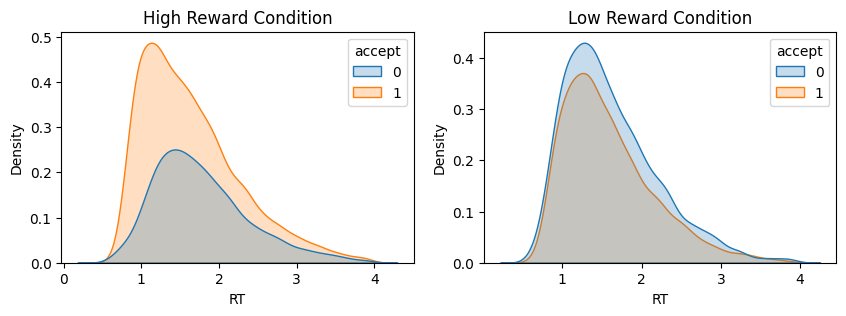

In [69]:
# For each condition, do a histogram of RT based on accept
# Figure with two subplots, one for each condition
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(data=data.query('condition == "equalIndifference"'), fill = True, x='RT', hue='accept', ax=axs[0])
sns.kdeplot(data=data.query('condition == "equalRange"'), fill = True, x='RT', hue='accept', ax=axs[1]) 
axs[0].set_title('High Reward Condition')
axs[1].set_title('Low Reward Condition')
plt.show()


### Visualization of acceptance rate

In [54]:
# add new column where its 0 if response_int is 1, 1/3 if its 2, 2/3 if its 3, 1 if its 4
data["prob_accept"] = data["response_int"].replace({1: 0, 2: 1/3, 3: 2/3, 4: 1})


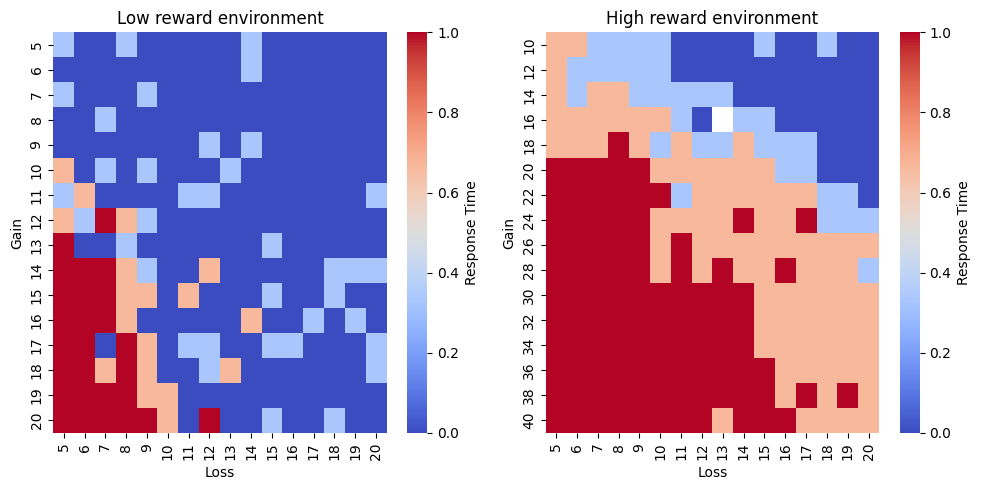

In [65]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalRange' & sub == 8").groupby(['gain', 'loss'])['prob_accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("Low reward environment")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference' & sub == 9").groupby(['gain', 'loss'])['prob_accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("High reward environment")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

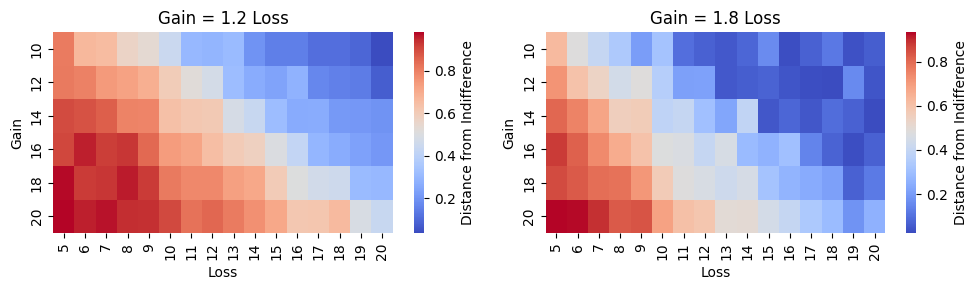

In [58]:
# Two figures: Acceptance rate per condition
shared_gains = [10, 12, 14, 16, 18, 20]
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
hmap_data = data.query("condition == 'equalRange' & gain in @shared_gains").groupby(['gain', 'loss'])['prob_accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Distance from Indifference'}, ax = axs[0])
axs[0].set_title("Gain = 1.2 Loss")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference' & gain in @shared_gains").groupby(['gain', 'loss'])['prob_accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Distance from Indifference'}, ax = axs[1])
axs[1].set_title("Gain = 1.8 Loss")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

In [12]:
shared_gains = [10, 12, 14, 16, 18, 20]
data.query("gain in @shared_gains")

,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial
0,1,1,equalIndifference,14,6,2.388,1,3.0,weakly_accept,1
3,1,1,equalIndifference,10,10,1.457,0,2.0,weakly_reject,4
4,1,1,equalIndifference,12,19,1.973,0,1.0,strongly_reject,5
5,1,1,equalIndifference,20,8,1.767,1,3.0,weakly_accept,6
7,1,1,equalIndifference,20,15,2.289,1,3.0,weakly_accept,8
...,...,...,...,...,...,...,...,...,...,...
27636,124,4,equalRange,10,16,1.340,0,1.0,strongly_reject,245
27638,124,4,equalRange,16,11,1.133,1,3.0,weakly_accept,247
27640,124,4,equalRange,16,8,1.339,1,4.0,strongly_accept,249
27642,124,4,equalRange,18,19,1.133,0,2.0,weakly_reject,251


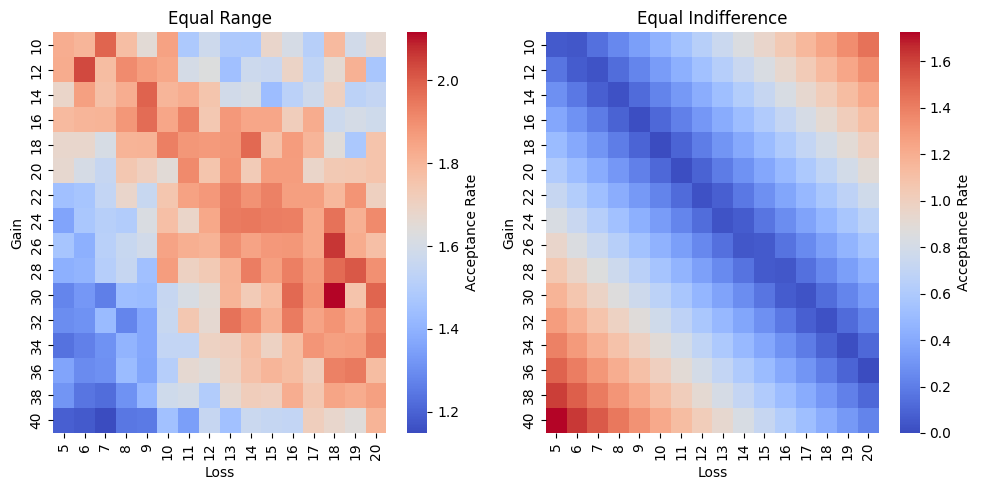

In [57]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['dist_from_indiff'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

Text(95.72222222222221, 0.5, 'Gain')

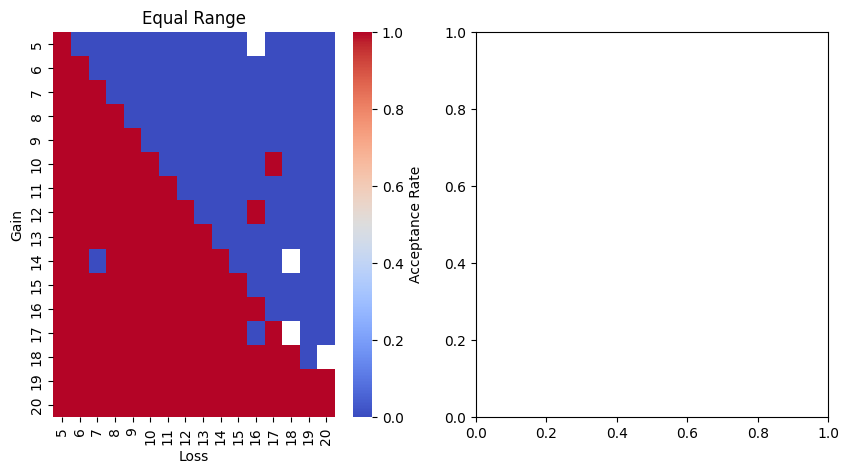

In [9]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("sub == 4").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")